In [1]:
import pymysql
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from item_embedding import item_encode
from preprocess_user import make_user_fans_pipeline
from etl import load_user_info_features
from etl import load_fans_info_features

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_auc_score,accuracy_score

from tensorflow.keras.layers import Input, Embedding, Dot, Add,Flatten,Dense,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD,Adam
import tensorflow as tf

/Users/huan/anaconda/envs/py3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def preprocess_goods():
    '''
        Get goods data
        Encode goods to vectors
        
        Parameters:
        
        Returns:
            encoded_items: (N_items, item_embedding_dimension)
            goods: goods dataframe
    '''
    conn = pymysql.connect(host = '127.0.0.1', 
                       user = 'root', 
                       password = 'root123', 
                       db = 'delidou')

    goods = pd.read_sql_query('''
        select g.* from base_goods g
        inner join(
            select distinct u.id as uid from base_user_info u
            inner join(
                select id from base_user_fans
            ) f on u.id = f.id
        ) uf on g.id = uf.uid
    ''', conn)
    
    encoded_items,goods = item_encode(goods)
    goods = goods.reset_index(drop = True)
    
    n_users = goods['id'].nunique()
    n_items = goods.link_id.nunique()
    n_pref = goods.shape[0]

    # print('Number of users: {}'.format(n_users))
    # print('Number of items: {}'.format(n_items))
    # print('Number of records: {}'.format(n_pref))
    
    return encoded_items, goods


def filter_goods_and_users(goods, user_n_item = 10, item_n_user = 10):
    '''
        Select top users and items
    '''
    
    item_count = goods.groupby('link_id')['id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'id',ascending = False)
    
    top_link_ids = item_count[item_count.id > item_n_user].link_id.values
    
    user_count = goods.groupby('id')['link_id']\
        .agg(lambda x:len(set(x))).reset_index()\
        .sort_values(by = 'link_id',ascending = False)
    
    top_user_ids = user_count[user_count.link_id > user_n_item].id.values
    
    goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids))]
    # goods = goods[(goods.id.isin(top_user_ids)) & (goods.link_id.isin(top_link_ids)) & (goods.id.isin(user_fans.id.values))]
    
    return goods,top_link_ids, top_user_ids



def load_user_features(n_regions = 30):
    
    '''Load user and fans data, process using predefined pipeline'''
    
    user = load_user_info_features()
    fans = load_fans_info_features()
    user_fans = user.merge(fans, on = 'id', how = 'inner')
    pipe = make_user_fans_pipeline(n_regions)
    user_features = pipe.fit_transform(user_fans)
    return user_features, user_fans



def userinfo_to_id(user_features, user_fans, user2id):
    result = []
    for user, f  in zip(user_fans.id.values, user_features):
        if user in user2id.keys():
            result.append([user2id[user],*f])

    user_features = pd.DataFrame(result)
    user_features.columns = ['user_id' if col == 0 else 'F_' + str(col) for col in user_features]
    user_features = user_features.iloc[:,1:]
    return user_features



def make_rating_table(goods):
    '''
        Make a 3 column rating table
    '''
    ratings = goods[['id','link_id']].copy()
    ratings['rating'] = 1
    ratings = ratings.rename(columns = {'id':'user_id','link_id':'item_id'})
    user2id = {user:i for i, user in enumerate(ratings.user_id.unique())}
    item2id = {item:i for i, item in enumerate(ratings.item_id.unique())}
    ratings['user_id'] = ratings['user_id'].replace(user2id)
    ratings['item_id'] = ratings['item_id'].replace(item2id)
    return ratings, user2id, item2id



def negative_sampling(ratings, n_negative = 50):
    '''
        Negative sampling
    '''
    all_items = set(ratings.item_id.unique())
    negative_samples = []
    for user_id in ratings.user_id.unique():
        user_items = set(ratings[ratings.user_id == user_id]['item_id'].tolist())
        space = list(all_items.difference(set(user_items)))
        neg_items = np.random.choice(space, size = n_negative)
        for neg_item in neg_items:
            negative_samples.append([user_id, neg_item,0])
    neg_ratings = pd.DataFrame(negative_samples,columns = ['user_id','item_id','rating'])
    dataset = pd.concat([ratings, neg_ratings])
    return dataset



def recommend_train_test_split(dataset, encoded_items, user_features, 
                               test_size = 0.1, shuffle = True):
    
    X_train, X_test, y_train,y_test =  train_test_split(dataset[['user_id','item_id']], 
                                                    dataset['rating'], 
                                                    test_size = 0.1, 
                                                    shuffle = True)

    item_encode_train = encoded_items[X_train.item_id.values]
    item_encode_test = encoded_items[X_test.item_id.values]
    
    user_feature_train = user_features.iloc[X_train.user_id.values,:]
    user_feature_test = user_features.iloc[X_test.user_id.values,:]
    
    
    print_info = '''
    ======================================
    Dataset Summary:
    ======================================
    X_train: {}
    X_test: {}
    item_encode_train: {}
    item_encode_test: {}
    user_feature_train: {}
    user_features_test: {}
    ======================================
    '''.format(X_train.shape, X_test.shape, 
               item_encode_train.shape, item_encode_test.shape, 
               user_feature_train.shape, user_feature_test.shape)
    
    print(print_info)
    
    return X_train, item_encode_train, user_feature_train,\
            X_test, item_encode_test, user_feature_test,y_train, y_test


def get_recommend_model(n_users, n_items, item_feature_dim, user_feature_dim, embed_hidden_dim = 10, reg = 0.):
    
    user_input = Input(1,)
    item_input = Input(1,)
    encoded_items_tensor = Input(item_feature_dim,)
    input_user_feature = Input(user_feature_dim,)

    user_embedding = Embedding(n_users,embed_hidden_dim, embeddings_regularizer=l2(reg))(user_input)
    item_embedding = Embedding(n_items,embed_hidden_dim, embeddings_regularizer=l2(reg))(item_input)

    user_bias = Embedding(n_users,1, embeddings_regularizer=l2(reg))(user_input)
    item_bias = Embedding(n_items,1, embeddings_regularizer=l2(reg))(item_input)

    rating_pred = Dot(axes = 2)([user_embedding, item_embedding])
    rating_pred = Add()([rating_pred, user_bias, item_bias])
    rating_pred = Flatten()(rating_pred)
    rating_pred = Concatenate()([rating_pred,encoded_items_tensor,input_user_feature])
    rating_pred = Dense(16, activation = 'relu')(rating_pred)
    rating_pred = Dense(1, activation = 'sigmoid')(rating_pred)

    model = Model([user_input, item_input,encoded_items_tensor,input_user_feature],rating_pred)
        
    model.compile(optimizer = Adam(lr = 0.001),loss = tf.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])
    return model
    
    
def evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test):
    
    # predict
    preds = (model.predict(x = [X_test.user_id.values,
                                X_test.item_id.values,
                                item_encode_test, 
                                user_feature_test]) > 0.5).flatten()
    
    confuse = confusion_matrix(y_test, preds)
    fig, ax = plt.subplots(figsize = (6,4))
    sns.heatmap(confuse / confuse.sum(), annot = True)
    plt.title('Confusion Matrix')
    plt.show()
    
    auc = roc_auc_score(y_test, preds)
    acc = accuracy_score(y_test, preds)
    print('Accuracy Score: {}'.format(acc))
    print('Auc score: {}'.format(auc))

In [3]:
# items related pipelines
encoded_items, goods = preprocess_goods()
goods, top_link_ids, top_user_ids = filter_goods_and_users(goods)
ratings, user2id, item2id = make_rating_table(goods)
id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

# user related pipelines
user_features, user_fans_df = load_user_features()
user_features = userinfo_to_id(user_features,user_fans_df,user2id)

# negative sampling ratings
dataset = negative_sampling(ratings)

# split and merge item and user data
X_train, item_encode_train, user_feature_train, \
    X_test, item_encode_test, user_feature_test,\
    y_train, y_test = recommend_train_test_split(dataset, 
                                                 encoded_items, 
                                                 user_features, 
                                                 test_size = 0.1,
                                                 shuffle = True)

# model structure based on data
model_params = dict(
    n_users = ratings.user_id.nunique(),
    n_items = ratings.item_id.nunique(),
    item_feature_dim = item_encode_train.shape[1],
    user_feature_dim = user_feature_train.shape[1],
    embed_hidden_dim = 10,
    reg = 0.
    )

# get the model
model = get_recommend_model(**model_params)

Building prefix dict from the default dictionary ...
I0809 16:53:16.150573 4626931136 __init__.py:111] Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
I0809 16:53:16.153606 4626931136 __init__.py:131] Loading model from cache /var/folders/jh/q3qgwx4n59b_rg88dkbcb20m0000gn/T/jieba.cache
Loading model cost 0.830 seconds.
I0809 16:53:16.982995 4626931136 __init__.py:163] Loading model cost 0.830 seconds.
Prefix dict has been built succesfully.
I0809 16:53:16.985170 4626931136 __init__.py:164] Prefix dict has been built succesfully.



    Dataset Summary:
    X_train: (151836, 2)
    X_test: (16871, 2)
    item_encode_train: (151836, 128)
    item_encode_test: (16871, 128)
    user_feature_train: (151836, 127)
    user_features_test: (16871, 127)
    


In [4]:
EPOCHS = 20

history = model.fit(x = [X_train.user_id.values,X_train.item_id.values,item_encode_train,user_feature_train.values],y = y_train.values,
                   epochs = EPOCHS,
                   batch_size = 1024,
                   validation_data = (
                   [X_test.user_id.values,X_test.item_id.values,item_encode_test,user_feature_test], y_test.values)
                   )

Train on 151836 samples, validate on 16871 samples
Epoch 1/20
151836/151836 [==============================] - 1s 7us/sample - loss: 0.4470 - accuracy: 0.8414 - val_loss: 0.4175 - val_accuracy: 0.8519
Epoch 2/20
151836/151836 [==============================] - 0s 3us/sample - loss: 0.4140 - accuracy: 0.8478 - val_loss: 0.4000 - val_accuracy: 0.8524
Epoch 3/20
151836/151836 [==============================] - 0s 3us/sample - loss: 0.3828 - accuracy: 0.8506 - val_loss: 0.3655 - val_accuracy: 0.8582
Epoch 4/20
151836/151836 [==============================] - 0s 3us/sample - loss: 0.3328 - accuracy: 0.8682 - val_loss: 0.3368 - val_accuracy: 0.8764
Epoch 5/20
151836/151836 [==============================] - 1s 3us/sample - loss: 0.2856 - accuracy: 0.8895 - val_loss: 0.3218 - val_accuracy: 0.8828
Epoch 6/20
151836/151836 [==============================] - 1s 4us/sample - loss: 0.2457 - accuracy: 0.9053 - val_loss: 0.3065 - val_accuracy: 0.8894
Epoch 7/20
151836/151836 [=======================

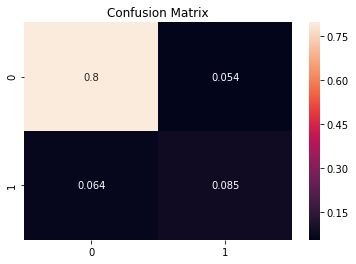

Accuracy Score: 0.8823424811807243
Auc score: 0.7536694314939809


In [5]:
evaluate_model(model, X_test, item_encode_test, user_feature_test,y_test)

In [6]:
def generate_recommends():
    all_items = set(ratings.item_id.unique())
    user = np.random.choice(X_test.user_id.values)
    user = np.repeat([user],len(all_items))  

    recos = np.argsort(model.predict([user, np.array(list(all_items)),encoded_items[list(all_items),],user_features.iloc[user].values]).flatten())[::-1][:30]
    goods[goods['id'] == id2user[user[0]]]

    print('Recommendation List:\n')
    for i, reco in enumerate(recos):
        print('No {}, Item: {}'.format(i+1,goods[goods.link_id == id2item[reco]]['name'].iloc[0]))

    print('\n\nKnown positive:\n')
    for i, good in enumerate(goods[goods['id'] == id2user[user[0]]]['name'].unique().tolist()):
        print('No {}, Item: {}'.format(i, good))

In [7]:
generate_recommends()

Recommendation List:

No 1, Item: 翰林精品 口才训练5本所谓情商高就是会说话别输在不会表达上 S
No 2, Item: iPhone6数据线苹果6s充电线器7plus手机5s加长8x弯头XS快充11pro冲电XR正品2米sp平板se闪充8p适用ipad短Max5
No 3, Item: 【一茶】 口才三绝 3册 为人三会 修心 三不 口才 职场 处世 沟通
No 4, Item: 卜珂麦丽素桶装怀旧黑巧克力夹心麦芽脆心球零食朱古力糖果送儿童
No 5, Item: 七年五季黑麦全麦面包整箱粗粮早餐低食品无蔗糖代餐脂肪热量吐司
No 6, Item: 【翰林精品】 受益一生的5本书狼道+鬼谷子+墨菲定律励志书籍
No 7, Item: 垃圾袋家用背心手提式加厚大号实惠装拉圾圾桶塑料袋中号黑色厨房
No 8, Item: 正宗咚派嗨吃家酸辣粉方便面6桶泡面整箱装速食食品螺蛳粉丝米线
No 9, Item: 欧亿姿洗脸巾一次性纯棉女抽取式卸妆棉柔巾洗面擦脸洁面巾纸专用
No 10, Item: EverWhite电动牙刷成人全自动声波防水软毛男女士学生党情侣牙刷
No 11, Item: 【爆优米】所谓情商高就是会说话别输在不会表达上说话心理学S
No 12, Item: 伊芳妮蒸汽眼罩缓解眼疲劳睡眠加热敷遮光睡觉仙女真丝舒缓发热男
No 13, Item: 靓涤垃圾袋家用手提式加厚实惠装一次性黑色背心拉圾桶塑料袋大号
No 14, Item: 捣蒜泥神器蒜泥蒜蓉机手动压蒜搅碎机迷你捣碎搅蒜器拉蒜打切大蒜
No 15, Item: 恋爱扭蛋机|恋爱扭扭蛋爱情兑换券情侣100件事创意生日礼物送男友
No 16, Item: 你的自律给你自由+愿你拼尽全力活出自己共5册 自律  青春励志
No 17, Item: 【有书共读】好书分享情商高就是会说话别输在不会表达上口才
No 18, Item: 快捷键鼠标垫超大防水鼠标垫
No 19, Item: 李茶德网红手摇手工抹茶冲泡饮品手冲原味珍珠奶茶速溶粉包袋装
No 20, Item: 全自动雨伞大号折叠遮阳防晒紫外线男女学生帅气晴雨两用超大太阳
No 21, Item: 所谓成长就是逼你学会坚强 慕容雪  青春文学暖心励志书H
No 22, Item: 爆翰林 全套10册鬼谷子谋略思维+口才